In [1]:
from math import exp, log, sqrt
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
plt.rcParams.update({'font.size': 10,
                     'legend.fontsize': 'x-large',
                     'figure.figsize': (15, 5),
                     'axes.labelsize': 'x-large',
                     'axes.titlesize':'x-large',
                     'xtick.labelsize':'x-large',
                     'ytick.labelsize':'x-large'})

# 1. Black-Scholes Model

The Black-Scholes formulas for the prices of European call and put options are:

\begin{equation}
c = S_0\mathcal{N}(d_+) - Ke^{-r\tau}\mathcal{N}(d_-)
\end{equation}

\begin{equation}
p = Ke^{-r\tau}\mathcal{N}(-d_-) - S_0\mathcal{N}(-d_+)
\end{equation}

where $d_{\pm} = \frac{\ln(S_0/K)+(r \pm \frac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}}$

In [3]:
def BSCall(spot, time, K, T, sigma, r):
    dp = (log(spot/K)+(r+0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    dm = (log(spot/K)+(r-0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    return spot*norm.cdf(dp) - K * exp(-r*(T - time))*norm.cdf(dm)

In [4]:
def BSPut(spot, time, K, T, sigma, r):
    dp = (log(spot/K)+(r+0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    dm = (log(spot/K)+(r-0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    return -spot*norm.cdf(-dp) + K * exp(-r*(T - time))*norm.cdf(-dm)

The relationship between each input and the option price is captured by sensitivity factors known as "the Greeks". In this notebook, I focus on two Greeks: Delta and Gamma.

Delta describes the relationship between changes in asset prices and changes in option prices. Delta for call and put options are given by:

\begin{equation}
\Delta_c = \mathcal{N}(d_+)
\end{equation}

\begin{equation}
\Delta_p = \mathcal{N}(d_-)
\end{equation}

Delta can also be interpreted as the slope of the prior-to-expiration curve. The delta of a call option is between 0 and 1. The delta of a put option is between -1 and 0.

In [5]:
def BSCall_Delta(spot, time, K, T, sigma, r):
    dp = (log(spot/K)+(r+0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    return norm.cdf(dp)

In [6]:
def BSPut_Delta(spot, time, K, T, sigma, r):
    dp = (log(spot/K)+(r+0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    return norm.cdf(dp) -1

Gamma measures the rate of change in delta as the underlying asset price changes. Gamma captures the curvature of the option-value-versus-stock-price relationship. Long positions in calls and puts have positive gammas, which are represented by the following equation:

\begin{equation}
\Gamma = \frac{\mathcal{N}'(d_+)}{S_0 \sigma \sqrt{\tau}}
\end{equation}

where $\mathcal{N}'(d_+) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}d^2_+}$

In [7]:
def BS_Gamma(spot, time, K, T, sigma, r):
    dp = (log(spot/K)+(r+0.5*sigma**2) * (T - time)) / (sigma * sqrt(T - time))
    return norm.pdf(dp)/(spot*sigma*sqrt(T-time))

In the Black-Scholes model, the tradable risky asset price $S = (S_t)_{t \geq 0}$ satisfies the stochastic differential equation:

\begin{equation}
dS_t = \mu S_t dt + \sigma S_t dW_t
\end{equation}

Solving the SDE, the asset price follows a lognormal distribution:

\begin{equation}
S_t = S_0 e^{\left(\mu - \frac{1}{2}\sigma^2 \right)t + \sigma W_t}
\end{equation}

In this project, I assume the following base parameters to simulate the asset price paths: $S_0 = 100$, $\sigma = 20\%$, $\mu = 10\%$, and $r = 2 \%$

In [8]:
# simulate the asset price path basic parameters
miu = 0.1     # drift rate
sigma = 0.2   # volatility
X0 = 100      # start price
r = 0.02      # risk free rate
T = 0.25      # time maturity, 1/4 year
K = 100       # strike price

In [9]:
# simulate the price path based on the black scholes asset price model
def AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps):
    
    dt = T / Nsteps # Time Increment
    dW0 = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    X = np.zeros((Npaths,Nsteps+1))
    t = np.array([i for i in range(0, Nsteps+1)])*dt
    X[:,0] = X0
    for i in range(1,Nsteps+1):
        X[:,i] = X[:,i-1]*np.exp((miu-0.5*sigma**2)*dt+sigma*dW0[:,i-1])
        
    return t, X

In [10]:
# asset price sample paths simulation parameters
Npaths = 100
Nsteps = 90
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

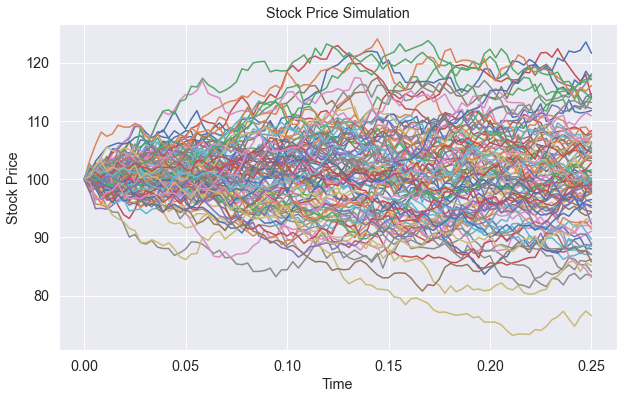

In [11]:
# asset price paths plot
fig, ax = plt.subplots(figsize=(10,6))
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Simulation")
for i in range(0,Npaths):
  plt.plot(t,X[i])

# 2. Delta Hedging

First, consider the self-financing strategy $(\alpha_t, \beta_t, -1)_{t \geq 0}$, where $\alpha_t$ denotes the position held in risky asset, $\beta_t$ denotes the position held in the bank account, and $-1$ refers to the short position of a European put option. The put option was sold at-the-money and matures in 3 months.

It is noted that the bank account $B_t$ earns the risk-free interest and satisfies:

\begin{equation}
dB_t = rB_tdt
\end{equation}

At the beginning when $t=0$, choose $\alpha_0$, $\beta_0$ such that the self-financing portfolio has a zero initial value, $V_0 = 0$.

In addition, the value of the portfolio satisfies:

\begin{equation}
V_t = \alpha_t S_t + \beta_t B_t - g_t \\
dV_t = \alpha_t dS_t + \beta_t dB_t - dg_t
\end{equation}

where $g$ is the option value.

I can expand the second SDE to include the Black-Scholes model

\begin{aligned}
dV_t 
&= \alpha_t(\mu S_t dt + \sigma S_t dW_t) + \beta_t rB_t dt - dg_t \\
\end{aligned}

Since the option value depends on $t$ and $S_t$, intuitively, I can apply Ito's lemma to find the dynamics of $g_t$ and in general form the SDE that $g_t$ satisfies is:

\begin{equation}
dg_t = \mu_t^g g_t dt + \sigma_t^g g_t dW_t
\end{equation}

Substitue the expression for $dS_t$, $dB_t$ and $dg_t$ into the portfolio value SDE:

\begin{equation}
dV_t = (\alpha_t \mu S_t + \beta_t r B_t - \mu_t^g g_t)dt + (\alpha_t \sigma S_t - \sigma_t^g g_t)dW_t
\end{equation}

To achieve an instantaneously risk-free portfolio, I must set the coefficient of $dW_t$ to be zero, since this is the source of all the noise in the portfolio.

\begin{aligned}
\alpha_t \sigma S_t - \sigma_t^g g_t = 0 \\
\Longrightarrow \alpha_t = \frac{\sigma_t^g g_t}{\sigma S_t}
\end{aligned}

Applying on Ito's lemma on $g_t$, I can get that $\sigma_t^g g_t = \sigma S_t \partial_S g(t,S_t)$ and plug that into the above formula, it can be seen that the position needs to take for the risky asset is:

\begin{equation}
\alpha_t = \partial_S g(t,S_t) = \text{delta of the option $g$}
\end{equation}

Delta represents the change in the option value due to an increase in the value of the underlying asset on which the option is written. The above result indicates that the investor needs to buy delta amount of stocks to hedge the initial short position at $t=0$. 

In this notebook, I have also considered a transaction cost for trading equity and option, the investor will be charged $\$0.005$ on every one unit of equity traded, and $\$0.01$ on every unit of options traded.

In dynamic hedging implementation, the investor needs to maintain a delta-neutral portfolio whose value is unaffected by (first-order) changes in the value of the underlying asset $S$.

The following table illustrates the concepts behind time-based delta hedging.

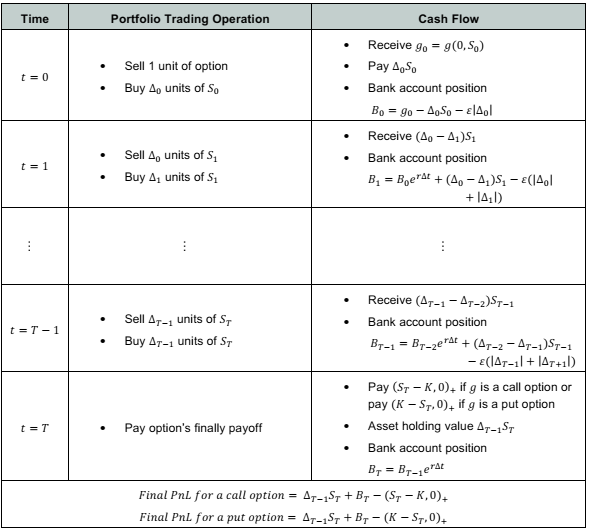

## 2.1 Time-Based Delta Hedging

### 2.1.1 Basic Functions

I simulate the daily asset price path, for hedging, I tried three different types to dynamically hedge the short put position, i.e., hedge every 3 days, hedge every 2 days, hedge everyday.

In [12]:
# rebalancing steps = asset simulation time step

def timebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps):

    dt = T / Nsteps

    # option value
    g = np.zeros((Npaths,Nsteps+1))

    # delta value
    alphat = np.zeros((Npaths,Nsteps+1))

    # bank account value
    B = np.zeros((Npaths,Nsteps+1))

    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))

    # PnL 
    PnL = np.zeros(Npaths)

    for i in range(Npaths):
        for j in range(0,Nsteps+1):

            time = j*dt
            spot = X[i,j]

            if j==0:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j])
                B[i,j] = g[i,j]-alphat[i,j]*X[i,j]-epsilon[i,j]

            elif j == Nsteps:
                g[i,j] = np.maximum(K-X[i,j],0)
                alphat[i,j] = alphat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)

            else:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])
                B[i,j] = B[i,j-1]*np.exp(r*dt) - (alphat[i,j]-alphat[i,j-1])*X[i,j] - epsilon[i,j]

    for i in range(Npaths):
        PnL[i] = alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]

    return PnL,alphat

In [13]:
# rebalancing time step * 2 = asset simulation time step

def timebaseddeltahedge2(X,T,K,sigma,miu,r,e1,Npaths,Nsteps):
    
    dt = T / Nsteps
    # option value
    g = np.zeros((Npaths,Nsteps+1)) 
    # delta value
    alphat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))
    # PnL 
    PnL = np.zeros(Npaths)

    for i in range(Npaths):
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j*2]

            if j==0:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j])
                B[i,j] = g[i,j]-alphat[i,j]*X[i,j*2]-epsilon[i,j]

            elif j == Nsteps:
                g[i,j] = np.maximum(K-X[i,j*2],0)
                alphat[i,j] = alphat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)

            else:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])
                B[i,j] = B[i,j-1]*np.exp(r*dt) - (alphat[i,j]-alphat[i,j-1])*X[i,j*2] - epsilon[i,j]

    for i in range(Npaths):
        PnL[i] = alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
        
    return PnL

In [14]:
# rebalancing time step * 3 = asset simulation time step

def timebaseddeltahedge3(X,T,K,sigma,miu,r,e1,Npaths,Nsteps):
    
    dt = T / Nsteps
    # option value
    g = np.zeros((Npaths,Nsteps+1))
    # delta value
    alphat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))
    # PnL 
    PnL = np.zeros(Npaths)

    for i in range(Npaths):
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j*3]

            if j==0:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j])
                B[i,j] = g[i,j]-alphat[i,j]*X[i,j*3]-epsilon[i,j]

            elif j == Nsteps:
                g[i,j] = np.maximum(K-X[i,j*3],0)
                alphat[i,j] = alphat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)

            else:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])
                B[i,j] = B[i,j-1]*np.exp(r*dt) - (alphat[i,j]-alphat[i,j-1])*X[i,j*3] - epsilon[i,j]

        for i in range(Npaths):
            PnL[i] = alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
            
    return PnL

## 2.2 Move-Based Delta Hedging

### 2.2.1 Put Option's Delta 

Based on the basic parameters, I tried first to see the put option's delta change over 1 year. This graph can help understand the move-based delta hedging, which means that the investor only change the hedging position whenever the delta of the put option has moved sufficiently large enough.

In [23]:
# simulate the asset price path basic parameters (Time maturity=1 year)
miu = 0.1     # drift rate
sigma = 0.2   # volatility
X0 = 100      # start price
r = 0.02      # risk free rate
T = 1         # time maturity, 1 year
K = 100       # strike price

In [24]:
# asset price sample paths simulation parameters
Npaths = 100
Nsteps = 365
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [25]:
# transaction cost
e1 = 0.005 # every one unit of equity traded
e2 = 0.01 # every one unit of option traded

In [26]:
# 365 time steps delta-hedging
PnL,alphat = timebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps)

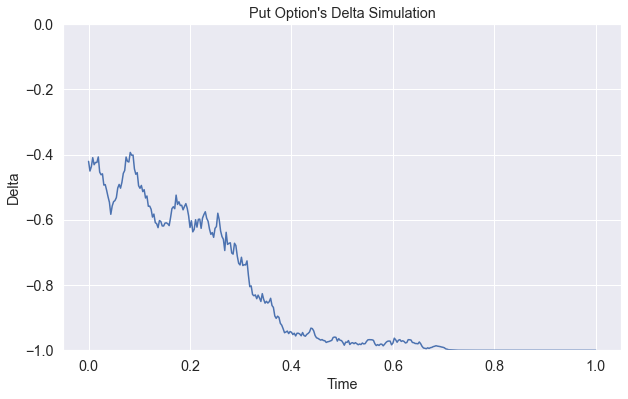

In [27]:
# 90 time steps delta plot 
fig, ax = plt.subplots(figsize=(10,6))
plt.xlabel("Time");
plt.ylabel("Delta");
plt.ylim(-1,0)
plt.title("Put Option's Delta Simulation");
plt.plot(t,alphat[25,:]);

### 2.2.2 Basic Functions

In [28]:
def movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth):
    
    dt = T / Nsteps
    # option value
    g = np.zeros((Npaths,Nsteps+1))
    # delta value
    alphat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))  
    # PnL 
    PnL = np.zeros(Npaths)   
    # Rebalancing Time
    Reb_Time = np.zeros((Npaths, Nsteps+1))
    
    for i in range(Npaths):     
        alphat[i,0] = BSPut_Delta(X[i,0], 0, K, T, sigma, r)
        last_reb_delta = alphat[i,0]
        upperband = last_reb_delta + bandwidth*0.5
        lowerband = last_reb_delta - bandwidth*0.5
        
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j]

            if j==0:
                g[i,j] = BSPut(spot, time, K, T, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j])
                B[i,j] = g[i,j]-alphat[i,j]*X[i,j]-epsilon[i,j]

            elif j == Nsteps:
                g[i,j] = np.maximum(K-X[i,j],0)
                alphat[i,j] = last_reb_delta
                B[i,j] = B[i,j-1]*np.exp(r*dt)

            else:
                alphat[i,j] = BSPut_Delta(spot, time, K, T, sigma, r)
                
                # current delta has touched the upper and lower band, need to rebalance the hedging portfolio
                if (alphat[i,j] >= upperband or alphat[i,j] <= lowerband):
                    
                    g[i,j] = BSPut(spot, time, K, T, sigma, r)
                    epsilon[i,j] = e1*np.abs(alphat[i,j]-last_reb_delta)
                    B[i,j] = B[i,j-1]*np.exp(r*dt) - (alphat[i,j]-last_reb_delta)*X[i,j] - epsilon[i,j]
                    Reb_Time[i,j] = time
                    last_reb_delta = alphat[i,j]
                    upperband = last_reb_delta + bandwidth*0.5
                    lowerband = last_reb_delta - bandwidth*0.5
                
                # otherwise, keep it as before
                else:
                    g[i,j] = BSPut(spot, time, K, T, sigma, r)
                    B[i,j] = B[i,j-1]*np.exp(r*dt)
                    
        PnL[i] = alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
        
    return PnL, epsilon

## 2.3 Compare Time-Based and Move-Based Delta Hedging

In [29]:
# simulate the asset price path basic parameters (Time maturity=0.25 year)
miu = 0.1     # drift rate
sigma = 0.2   # volatility
X0 = 100      # start price
r = 0.02      # risk free rate
T = 0.25      # time maturity, 0.25 year
K = 100       # strike price

In [30]:
# asset price sample paths simulation parameters
Npaths = 1000
Nsteps = 270
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [31]:
# To set different frequency of time steps
Nsteps1=270
Nsteps2=135
Nsteps3=90

In [32]:
# time-based delta hedging - 270 rebalancing timesteps
TDH,alphat =timebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps1)

In [33]:
# time-based delta hedging - 135 rebalancing timesteps
TDH2=timebaseddeltahedge2(X,T,K,sigma,miu,r,e1,Npaths,Nsteps2)

In [34]:
# time-based delta hedging - 90 rebalancing timesteps
TDH3=timebaseddeltahedge3(X,T,K,sigma,miu,r,e1,Npaths,Nsteps3)

In [35]:
# move-based delta hedging
# move-based is in terms of the possible observation times with 270 timesteps
bandwidth=0.05
MDH, epsilon = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps1,bandwidth)

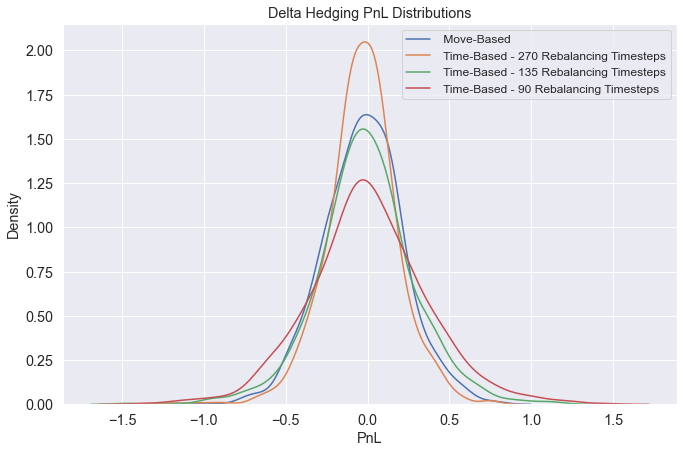

In [40]:
# Compare move-based delta and time-based delta under different rebalancing timesteps
fig, ax = plt.subplots(figsize=(11,7))
# plot move-based delta-gamma with 90 time steps
sns.kdeplot(MDH,label=" Move-Based");
# plot time-based delta hedging with 90 time steps
sns.kdeplot(TDH,label=" Time-Based - 270 Rebalancing Timesteps");
# plot time-based delta hedging with 45 time steps
sns.kdeplot(TDH2,label=" Time-Based - 135 Rebalancing Timesteps");
# plot time-based delta hedging with 30 time steps
sns.kdeplot(TDH3,label=" Time-Based - 90 Rebalancing Timesteps");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("Delta Hedging PnL Distributions")
plt.legend(fontsize=12,loc='best');

# Delta-Gamma Hedging Functions

## Time-Based Delta-Gamma Hedging Functions

In [ ]:
# rebalancing steps = asset simulation time step

def deltagammatimehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps):
    """
    Tg = put option maturity
    Th = call option maturity
    """
    dt = Tg / Nsteps
    #option value
    g = np.zeros((Npaths,Nsteps+1))
    #option value
    h = np.zeros((Npaths,Nsteps+1))    
    # delta hedge position
    alphat = np.zeros((Npaths,Nsteps+1))
    # gamma hedge position
    etat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))    
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))    
    # PnL 
    PnL = np.zeros(Npaths)
    
    for i in range(Npaths):
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j]

            if j==0:
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)               
                epsilon[i,j] = e1*np.abs(alphat[i,j])+e2*np.abs(etat[i,j])
                B[i,j]=g[i,j]-alphat[i,j]*X[i,j]-etat[i,j]*h[i,j]-epsilon[i,j]
            
            elif j==Nsteps:
                g[i,j] = np.maximum(K-X[i,j],0)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = alphat[i,j-1]
                etat[i,j] = etat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)
            
            else: 
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])+e2*np.abs(etat[i,j]-etat[i,j-1])              
                B[i,j]=B[i,j-1]*np.exp(r*dt)-(alphat[i,j]-alphat[i,j-1])*X[i,j]-(etat[i,j]-etat[i,j-1])*h[i,j]-epsilon[i,j]
                
    for i in range(Npaths):
        PnL[i] = etat[i,-1]* h[i,-1] + alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
    return PnL

In [ ]:
# rebalancing steps * 2 = asset simulation time step

def deltagammatimehedge2(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps):
    dt = Tg / Nsteps    
    #option value
    g = np.zeros((Npaths,Nsteps+1))
    #option value
    h = np.zeros((Npaths,Nsteps+1))    
    # delta hedge position
    alphat = np.zeros((Npaths,Nsteps+1))
    # gamma hedge position
    etat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))  
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))  
    # PnL 
    PnL = np.zeros(Npaths)

    for i in range(Npaths):
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j*2]

            if j==0:
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)               
                epsilon[i,j] = e1*np.abs(alphat[i,j])+e2*np.abs(etat[i,j])
                B[i,j]=g[i,j]-alphat[i,j]*X[i,j*2]-etat[i,j]*h[i,j]-epsilon[i,j]
            
            elif j==Nsteps:
                g[i,j] = np.maximum(K-X[i,j*2],0)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = alphat[i,j-1]
                etat[i,j] = etat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)
            
            else: 
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])+e2*np.abs(etat[i,j]-etat[i,j-1])              
                B[i,j]=B[i,j-1]*np.exp(r*dt)-(alphat[i,j]-alphat[i,j-1])*X[i,j*2]-(etat[i,j]-etat[i,j-1])*h[i,j]-epsilon[i,j]
                
    for i in range(Npaths):
        PnL[i] = etat[i,-1]* h[i,-1] + alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
    
    return PnL

In [ ]:
# rebalancing steps * 3 = asset simulation time step

def deltagammatimehedge3(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps):
    dt = Tg / Nsteps
    #option value
    g = np.zeros((Npaths,Nsteps+1))
    #option value
    h = np.zeros((Npaths,Nsteps+1))   
    # delta hedge position
    alphat = np.zeros((Npaths,Nsteps+1))
    # gamma hedge position
    etat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))    
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))   
    # PnL 
    PnL = np.zeros(Npaths)

    for i in range(Npaths):
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j*3]

            if j==0:
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)               
                epsilon[i,j] = e1*np.abs(alphat[i,j])+e2*np.abs(etat[i,j])
                B[i,j]=g[i,j]-alphat[i,j]*X[i,j*3]-etat[i,j]*h[i,j]-epsilon[i,j]
            
            elif j==Nsteps:
                g[i,j] = np.maximum(K-X[i,j*3],0)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = alphat[i,j-1]
                etat[i,j] = etat[i,j-1]
                B[i,j] = B[i,j-1]*np.exp(r*dt)
            
            else: 
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j]-alphat[i,j-1])+e2*np.abs(etat[i,j]-etat[i,j-1])              
                B[i,j]=B[i,j-1]*np.exp(r*dt)-(alphat[i,j]-alphat[i,j-1])*X[i,j*3]-(etat[i,j]-etat[i,j-1])*h[i,j]-epsilon[i,j]
                
    for i in range(Npaths):
        PnL[i] = etat[i,-1]* h[i,-1] + alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
    return PnL

## Move-Based Delta-Gamma Hedging Functions

In [ ]:
def deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth):  
    dt = Tg / Nsteps
    #option value
    g = np.zeros((Npaths,Nsteps+1))
    #option value
    h = np.zeros((Npaths,Nsteps+1))
    # delta hedge position
    alphat = np.zeros((Npaths,Nsteps+1))
    # gamma hedge position
    etat = np.zeros((Npaths,Nsteps+1))
    # bank account value
    B = np.zeros((Npaths,Nsteps+1))  
    # transaction cost
    epsilon = np.zeros((Npaths,Nsteps+1))
    # PnL 
    PnL = np.zeros(Npaths)
    # Rebalancing Time
    Reb_Time = np.zeros((Npaths, Nsteps+1))
    
    for i in range(Npaths):
        alphat[i,0] = BSPut_Delta(X[i,0], 0, K, Tg, sigma, r)-(BS_Gamma(X[i,0], 0, K, Tg, sigma, r)/BS_Gamma(X[i,0], 0, K, Th, sigma, r))*BSCall_Delta(X[i,0], 0, K, Th, sigma, r)
        etat[i,0] = BS_Gamma(X[i,0], 0, K, Tg, sigma, r)/BS_Gamma(X[i,0], 0, K, Th, sigma, r)               

        last_reb_alpha = alphat[i,0]
        last_reb_eta =  etat[i,0]
        upperband = last_reb_alpha + bandwidth*0.5
        lowerband = last_reb_alpha - bandwidth*0.5
        
        for j in range(0,Nsteps+1):
            time = j*dt
            spot = X[i,j]

            if j==0:
                g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                epsilon[i,j] = e1*np.abs(alphat[i,j])+e2*np.abs(etat[i,j])
                B[i,j]=g[i,j]-alphat[i,j]*X[i,j]-etat[i,j]*h[i,j]-epsilon[i,j]
            
            elif j==Nsteps:
                g[i,j] = np.maximum(K-X[i,j],0)
                h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                alphat[i,j] = last_reb_alpha
                etat[i,j] = last_reb_eta
                B[i,j] = B[i,j-1]*np.exp(r*dt)
            
            else: 
                alphat[i,j] = BSPut_Delta(spot, time, K, Tg, sigma, r)-(BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r))*BSCall_Delta(spot, time, K, Th, sigma, r)
                
                if (alphat[i,j] >= upperband or alphat[i,j] <= lowerband):
                    g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                    h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                    etat[i,j] = BS_Gamma(spot, time, K, Tg, sigma, r)/BS_Gamma(spot, time, K, Th, sigma, r)
                    epsilon[i,j] = e1*np.abs(alphat[i,j]-last_reb_alpha)+e2*np.abs(etat[i,j]-last_reb_eta)              
                    B[i,j]=B[i,j-1]*np.exp(r*dt)-(alphat[i,j]-last_reb_alpha)*X[i,j]-(etat[i,j]-last_reb_eta)*h[i,j]-epsilon[i,j]
                    Reb_Time[i,j] = time
                    last_reb_alpha = alphat[i,j]
                    last_reb_eta = etat[i,j]
                    upperband = last_reb_alpha + bandwidth*0.5
                    lowerband = last_reb_alpha - bandwidth*0.5
               
                else:
                    g[i,j] = BSPut(spot, time, K, Tg, sigma, r)
                    h[i,j] = BSCall(spot, time, K, Th, sigma, r)
                    B[i,j]=B[i,j-1]*np.exp(r*dt)
                    
    for i in range(Npaths):
        PnL[i] = etat[i,-1]* h[i,-1] + alphat[i,-1]*X[i,-1]+B[i,-1]-g[i,-1]
    return PnL, epsilon

### Plots for Report Section 3.1.2

In [ ]:
Tg = 0.25 # put option maturity
Th = 0.5  # call option maturity

In [ ]:
# time-based delta-gamma hedging - 270 rebalancing timesteps
TDGH  = deltagammatimehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps1)

In [ ]:
# time-based delta-gamma hedging - 135 rebalancing timesteps
TDGH2 = deltagammatimehedge2(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps2)

In [ ]:
# time-based delta-gamma hedging - 90 rebalancing timesteps
TDGH3 = deltagammatimehedge3(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps3)

In [ ]:
# move-based delta-gamma hedging
MDGH,epsilong  = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps1, bandwidth)

In [ ]:
# Compare move-based delta and time-steps delta under different timesteps
fig, ax = plt.subplots(figsize=(10,6))
# plot move-based delta-gamma with 90 time steps
sns.kdeplot(MDGH,label=" Move-Based");
# plot time-based delta-gamma hedging with 270 time steps
sns.kdeplot(TDGH,label=" Time-Based - 270 Rebalancing Timesteps");
# plot time-based delta-gamma hedging with 135 time steps
sns.kdeplot(TDGH3,label=" Time-Based - 135 Rebalancing Timesteps");
# plot time-based delta-gamma hedging with 90 time steps
sns.kdeplot(TDGH2,label=" Time-Based - 90 Rebalancing Timesteps");
ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("Delta-Gamma Hedging PnL Distributions")
plt.legend(fontsize=13);

# Simulation

## Real-World Volatility = 15%

In [ ]:
# Consider the situation when real world sigma=15% while risk neutral Q sigma=20%
# asset price sample paths simulation parameters

Npaths = 1000     # no. of simulations
Nsteps = 90       # time steps
real_sigma1=0.15  # real world volatility
miu = 0.1         # drift rate
X0 = 100          # starting price 
T = 0.25          # put option maturity
X_sim1 = X0 * np.ones(Npaths)
t_real1, X_real1 = AssetPricePaths(X_sim1, T, miu, real_sigma1, Npaths, Nsteps)

In [ ]:
# simulate time-based delta hedging PnL
K = 100     # put option strike price
r = 0.02    # risk-free rate
e1 = 0.005  # one unit of equity trade transaction cost
sigma = 0.2 # risk neutural volatility
PnL_TBD1,alphat = timebaseddeltahedge(X_real1,T,K,sigma,miu,r,e1,Npaths,Nsteps)

In [ ]:
# simulate move-based delta hedge
bandwidth = 0.05
PnL_MBD1,epsilon = movebaseddeltahedge(X_real1,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth)

In [ ]:
# simulate time-based delta-gamma hedge
e2 = 0.01  # one unit of option trade transaction cost
Tg = 0.25  # put option maturity
Th = 0.5   # call option maturity
PnL_TDGH1 = deltagammatimehedge(X_real1,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps)

In [ ]:
# simulate move-based delta-gamma hedge
PnL_MDGH1, epsilong = deltagammamovehedge(X_real1,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
# plot time-based delta hedge
sns.kdeplot(PnL_TBD1,label="Time-Based Delta Hedging",color="k");

# plot move-based delta hedge
sns.kdeplot(PnL_MBD1,label="Move-Based Delta Hedging");

# plot time-based delta-gamma hedge
sns.kdeplot(PnL_TDGH1,label="Time-Based Delta-Gamma Hedging");

# plot move-based delta-gamma hedge
sns.kdeplot(PnL_MDGH1,label="Move-Based Delta-Gamma Hedging");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution with Realized Volatility of 15%")
plt.legend();

## Real-World Volatility = 20%

In [ ]:
# Consider the situation when real world sigma=25% while risk neutral Q sigma=20%
# asset price sample paths simulation parameters

Npaths = 1000     # no. of simulations
Nsteps = 90       # time steps
sigma=0.2         # real world volatility & risk neutral volatility
miu = 0.1         # drift rate
X0 = 100          # starting price 
T = 0.25          # put option maturity
X_sim = X0 * np.ones(Npaths)
t_real, X_real = AssetPricePaths(X_sim, T, miu, sigma, Npaths, Nsteps)

In [ ]:
# simulate time-based delta hedging PnL
K = 100     # put option strike price
r = 0.02    # risk-free rate
e1 = 0.005  # one unit of equity trade transaction cost
PnL_TBD, alphat = timebaseddeltahedge(X_real,T,K,sigma,miu,r,e1,Npaths,Nsteps)

In [ ]:
# simulate move-based delta hedge
bandwidth = 0.05
PnL_MBD,epsilon = movebaseddeltahedge(X_real,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth)

In [ ]:
# simulate time-based delta-gamma hedge
e2 = 0.01  # one unit of option trade transaction cost
Tg = 0.25  # put option maturity
Th = 0.5   # call option maturity
PnL_TDGH = deltagammatimehedge(X_real,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps)

In [ ]:
# simulate move-based delta-gamma hedge
PnL_MDGH, epsilong = deltagammamovehedge(X_real,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# plot time-based delta hedge
sns.kdeplot(PnL_TBD,label="Time-Based Delta Hedging",color="k");

# plot move-based delta hedge
sns.kdeplot(PnL_MBD,label="Move-Based Delta Hedging");

# plot time-based delta-gamma hedge
sns.kdeplot(PnL_TDGH,label="Time-Based Delta-Gamma Hedging");

# plot move-based delta-gamma hedge
sns.kdeplot(PnL_MDGH,label="Move-Based Delta-Gamma Hedging");
ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution with Realized Volatility of 20%")
plt.legend(fontsize=13);

## Real-World Volatility = 25%

In [ ]:
# Consider the situation when real world sigma=25% while risk neutral Q sigma=20%
# asset price sample paths simulation parameters

Npaths = 1000     # no. of simulations
Nsteps = 90       # time steps
real_sigma2=0.25  # real world volatility
miu = 0.1         # drift rate
X0 = 100          # starting price 
T = 0.25          # put option maturity
X_sim2 = X0 * np.ones(Npaths)
t_real2, X_real2 = AssetPricePaths(X_sim2, T, miu, real_sigma2, Npaths, Nsteps)

In [ ]:
# simulate time-based delta hedging PnL
K = 100     # put option strike price
r = 0.02    # risk-free rate
e1 = 0.005  # one unit of equity trade transaction cost
sigma = 0.2 # risk neutural volatility
PnL_TBD2,alphat = timebaseddeltahedge(X_real2,T,K,sigma,miu,r,e1,Npaths,Nsteps)

In [ ]:
# simulate move-based delta hedge
bandwidth = 0.05
PnL_MBD2,epsilon = movebaseddeltahedge(X_real2,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth)

In [ ]:
# simulate time-based delta-gamma hedge
e2 = 0.01  # one unit of option trade transaction cost
Tg = 0.25  # put option maturity
Th = 0.5   # call option maturity
PnL_TDGH2 = deltagammatimehedge(X_real2,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps)

In [ ]:
# simulate move-based delta-gamma hedge
PnL_MDGH2,epsilong = deltagammamovehedge(X_real2,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# plot time-based delta hedge
sns.kdeplot(PnL_TBD2,label="Time-Based Delta Hedging",color="k");

# plot move-based delta hedge
sns.kdeplot(PnL_MBD2,label="Move-Based Delta Hedging");

# plot time-based delta-gamma hedge
sns.kdeplot(PnL_TDGH2,label="Time-Based Delta-Gamma Hedging");

# plot move-based delta-gamma hedge
sns.kdeplot(PnL_MDGH2,label="Move-Based Delta-Gamma Hedging");
ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution with Realized Volatility of 25%")
plt.legend();

## Hedging Under Different Sigma

In [ ]:
# Plot time-based delta hedge PnL distribution under different sigma
fig, ax = plt.subplots(figsize=(10,6))
# plot time-based delta hedge under 15% Sigma
sns.kdeplot(PnL_TBD1,label="Real-World Volatility = 15%");
# plot time-based delta hedge under 20% Sigma
sns.kdeplot(PnL_TBD,label="Real-World Volatility = 20%");
# plot time-based delta hedge under 25% Sigma
sns.kdeplot(PnL_TBD2,label="Real-World Volatility = 25%");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution of Time-Based Delta Hedging")
plt.legend();

In [ ]:
# Plot move-based delta hedge PnL distribution under different sigma
fig, ax = plt.subplots(figsize=(10,6))
# plot move-based delta hedge under 15% Sigma
sns.kdeplot(PnL_MBD1,label="Real-World Volatility = 15%");
# plot move-based delta hedge under 20% Sigma
sns.kdeplot(PnL_MBD,label="Real-World Volatility = 20%");
# plot move-based delta hedge under 25% Sigma
sns.kdeplot(PnL_MBD2,label="Real-World Volatility = 25%");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution of Move-Based Delta Hedging")
plt.legend();

In [ ]:
# Plot time-based delta-gamma hedge PnL distribution under different sigma
fig, ax = plt.subplots(figsize=(10,6))
# plot time-based delta-gamma hedge under 15% Sigma
sns.kdeplot(PnL_TDGH1,label="Real-World Volatility = 15%");
# plot time-based delta-gamma hedge under 20% Sigma
sns.kdeplot(PnL_TDGH,label="Real-World Volatility = 20%");
# plot time-based delta-gamma hedge under 25% Sigma
sns.kdeplot(PnL_TDGH2,label="Real-World Volatility = 25%");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution of Time-Based Delta-Gamma Hedging")
plt.legend();

In [ ]:
# Plot move-based delta-gamma hedge PnL distribution under different sigma
fig, ax = plt.subplots(figsize=(10,6))
# plot move-based delta-gamma hedge under 15% Sigma
sns.kdeplot(PnL_MDGH1,label="Real-World Volatility = 15%");
# plot move-based delta-gamma hedge under 20% Sigma
sns.kdeplot(PnL_MDGH,label="Real-World Volatility = 20%");
# plot move-based delta-gamma hedge under 25% Sigma
sns.kdeplot(PnL_MDGH2,label="Real-World Volatility = 25%");

ax.set_xlabel("PnL")
ax.set_ylabel("Density")
ax.set_title("PnL Distribution of Move-Based Delta-Gamma Hedging")
plt.legend();

# Role of Rebalancing-Band 

## Move-Based Delta Hedging Time Step = 90

In [ ]:
Npaths = 1000
Nsteps = 90

In [ ]:
# simulate the asset price path basic parameters (Time maturity=0.25 year)
miu = 0.1     # drift rate
sigma = 0.2   # volatility
X0 = 100      # start price
r = 0.02      # risk free rate
T = 0.25      # time maturity, 0.25 year
K = 100       # strike price

In [ ]:
# asset price sample paths simulation parameters
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [ ]:
# Generate PnL and transaction costs under move-based delta hedging with varying bandwidth
PnL_move_deltah1,epsilon1 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.15)
PnL_move_deltah2,epsilon2 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.1)
PnL_move_deltah3,epsilon3 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.05)
PnL_move_deltah4,epsilon4 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.025)
PnL_move_deltah5,epsilon5 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.01)

In [ ]:
# Plot the KDE plots of PnL under move-based delta hedging with varying bandwidth
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(PnL_move_deltah1, label = 'Bandwidth = 0.15')
sns.kdeplot(PnL_move_deltah2, label = 'Bandwidth = 0.1')
sns.kdeplot(PnL_move_deltah3, label = 'Bandwidth = 0.05')
sns.kdeplot(PnL_move_deltah4, label = 'Bandwidth = 0.025')
sns.kdeplot(PnL_move_deltah5, label = 'Bandwidth = 0.01')

plt.title('KDE of Move-Based Delta Hedge PnL (90 Timesteps)')
plt.xlabel('PnL')
plt.ylabel('Density')
plt.legend();

## Move-Based Delta-Hedging Time Step = 270

In [ ]:
Npaths = 1000
Nsteps = 270

In [ ]:
# asset price sample paths simulation parameters
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [ ]:
# Generate PnL and transaction costs under move-based delta hedging with varying bandwidth
PnL_move_deltah1,epsilon1 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.15)
PnL_move_deltah2,epsilon2 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.1)
PnL_move_deltah3,epsilon3 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.05)
PnL_move_deltah4,epsilon4 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.025)
PnL_move_deltah5,epsilon5 = movebaseddeltahedge(X,T,K,sigma,miu,r,e1,Npaths,Nsteps,bandwidth=0.01)

In [ ]:
# Plot the KDE plots of PnL under move-based delta hedging with varying bandwidth
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(PnL_move_deltah1, label = 'Bandwidth = 0.15')
sns.kdeplot(PnL_move_deltah2, label = 'Bandwidth = 0.1')
sns.kdeplot(PnL_move_deltah3, label = 'Bandwidth = 0.05')
sns.kdeplot(PnL_move_deltah4, label = 'Bandwidth = 0.025')
sns.kdeplot(PnL_move_deltah5, label = 'Bandwidth = 0.01')

plt.title('KDE of Move-Based Delta Hedge PnL (270 Timesteps)')
plt.xlabel('PnL')
plt.ylabel('Density')
plt.legend();

## Move-Based Delta-Gamma Hedging Time Step = 90

In [ ]:
# To set different frequency of time steps
Nsteps=90
X0 = 100      # start price
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [ ]:
PnL_move_dgh1, epsilon1g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.15)
PnL_move_dgh2, epsilon2g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.1)
PnL_move_dgh3, epsilon3g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.05)
PnL_move_dgh4, epsilon4g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.025)
PnL_move_dgh5, epsilon5g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.01)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(PnL_move_dgh1, label = 'Bandwidth = 0.15')
sns.kdeplot(PnL_move_dgh2, label = 'Bandwidth = 0.1')
sns.kdeplot(PnL_move_dgh3, label = 'Bandwidth = 0.05')
sns.kdeplot(PnL_move_dgh4, label = 'Bandwidth = 0.025')
sns.kdeplot(PnL_move_dgh5, label = 'Bandwidth = 0.01')

plt.title('KDE of Move-Based Delta-Gamma Hedge PnL (90 Timesteps)')
plt.xlabel('Profit and Loss')
plt.ylabel('Density')

plt.legend()
plt.show()

## Move-Based Delta-Gamma Hedging Time Step = 270

In [ ]:
Npaths = 1000
Nsteps = 270

In [ ]:
# asset price sample paths simulation parameters
X0 = X0 * np.ones(Npaths)
t, X = AssetPricePaths(X0, T, miu, sigma, Npaths, Nsteps)

In [ ]:
PnL_move_dgh1, epsilon1g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.15)
PnL_move_dgh2, epsilon2g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.1)
PnL_move_dgh3, epsilon3g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.05)
PnL_move_dgh4, epsilon4g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.025)
PnL_move_dgh5, epsilon5g = deltagammamovehedge(X,Tg,Th,K,sigma,miu,r,e1,e2,Npaths,Nsteps, bandwidth=0.01)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(PnL_move_dgh1, label = 'Bandwidth = 0.15')
sns.kdeplot(PnL_move_dgh2, label = 'Bandwidth = 0.1')
sns.kdeplot(PnL_move_dgh3, label = 'Bandwidth = 0.05')
sns.kdeplot(PnL_move_dgh4, label = 'Bandwidth = 0.025')
sns.kdeplot(PnL_move_dgh5, label = 'Bandwidth = 0.01')

plt.title('KDE of Move-Based Delta-Gamma Hedge PnL (270 Timesteps)')
plt.xlabel('Profit and Loss')
plt.ylabel('Density')

plt.legend()
plt.show()

## Transaction Costs vs. Relancing Bandwidth

In [ ]:
# Generate average transaction costs 
ep_move_deltah1 = np.mean(np.sum(epsilon1,axis=1))
ep_move_deltah2 = np.mean(np.sum(epsilon2,axis=1))
ep_move_deltah3 = np.mean(np.sum(epsilon3,axis=1))
ep_move_deltah4 = np.mean(np.sum(epsilon4,axis=1))
ep_move_deltah5 = np.mean(np.sum(epsilon5,axis=1))
ep_move_delta = list([ep_move_deltah1,ep_move_deltah2,ep_move_deltah3,ep_move_deltah4,ep_move_deltah5])

ep_move_dgh1 = np.mean(np.sum(epsilon1g,axis=1))
ep_move_dgh2 = np.mean(np.sum(epsilon2g,axis=1))
ep_move_dgh3 = np.mean(np.sum(epsilon3g,axis=1))
ep_move_dgh4 = np.mean(np.sum(epsilon4g,axis=1))
ep_move_dgh5 = np.mean(np.sum(epsilon5g,axis=1))
ep_move_dg = list([ep_move_dgh1,ep_move_dgh2,ep_move_dgh3,ep_move_dgh4,ep_move_dgh5])

# Plot average transaction costs for delta and delta-gamma hedge
bandwidth_set = list([0.15,0.1,0.05,0.025,0.01])
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(bandwidth_set,ep_move_delta, label='Delta Hedge')
plt.plot(bandwidth_set,ep_move_dg,label='Delta-Gamma Hedge')

plt.title('Average Transaction Costs vs. Rebalancing Bandwidth')
plt.xlabel('Bandwidth')
plt.ylabel('Cost')
plt.ylim(0,0.35)
plt.legend()
plt.show()